In [1]:
!pip install numpy yfinance scikit-learn torch kan pycaret --upgrade

  Using cached numpy-2.0.2-cp39-cp39-win_amd64.whl.metadata (59 kB)
  Using cached scikit_learn-1.5.2-cp39-cp39-win_amd64.whl.metadata (13 kB)


In [2]:
!pip install --no-build-isolation scikit-learn

In [6]:
!pip install cython==0.29.37

  Using cached Cython-0.29.37-py2.py3-none-any.whl.metadata (3.1 kB)
Using cached Cython-0.29.37-py2.py3-none-any.whl (989 kB)
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.11
    Uninstalling Cython-3.0.11:
      Successfully uninstalled Cython-3.0.11


In [10]:
import yfinance as yf
import pandas as pd
import numpy as np
import sklearn
import torch
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from kan import *

In [80]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [82]:
device = torch.device('cuda')

In [83]:
device

device(type='cuda')

In [84]:
ticker = "^GSPC"  # S&P 500
data = yf.download(ticker, start="2010-01-01", end="2023-01-01")

[*********************100%***********************]  1 of 1 completed


In [85]:
data['return'] = data['Adj Close'].pct_change()  #daily returns
data['sma_50'] = data['Adj Close'].rolling(window=50).mean()  # 50 day ma
data['sma'] = data['Adj Close'].rolling(window=200).mean()  # 200 day ma
data = data.dropna()

In [86]:
data

Price,Adj Close,Close,High,Low,Open,Volume,return,sma_50,sma
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,,,
Date,,,,,,,,,
2010-10-18 00:00:00+00:00,1184.709961,1184.709961,1185.530029,1174.550049,1176.829956,4450050000,0.007244,1116.760398,1120.764647
2010-10-19 00:00:00+00:00,1165.900024,1165.900024,1178.640015,1159.709961,1178.640015,5600120000,-0.015877,1117.522598,1120.929197
2010-10-20 00:00:00+00:00,1178.170044,1178.170044,1182.939941,1166.739990,1166.739990,5027880000,0.010524,1118.664797,1121.137447
2010-10-21 00:00:00+00:00,1180.260010,1180.260010,1189.430054,1171.170044,1179.819946,4625470000,0.001774,1120.480598,1121.353047
2010-10-22 00:00:00+00:00,1183.079956,1183.079956,1183.930054,1178.989990,1180.520020,3177890000,0.002389,1122.469998,1121.559997
...,...,...,...,...,...,...,...,...,...
2022-12-23 00:00:00+00:00,3844.820068,3844.820068,3845.800049,3797.010010,3815.110107,2819280000,0.005868,3885.761816,4016.858315
2022-12-27 00:00:00+00:00,3829.250000,3829.250000,3846.649902,3813.219971,3843.340088,3030300000,-0.004050,3890.685415,4014.983015


In [87]:
X = data[['return', 'sma_50', 'sma']]  # Feature set
y = data['Adj Close'].shift(-1)  # Target variable: next day's closing price

In [88]:
X = X[:-1]
y = y[:-1]

In [89]:
tscv = TimeSeriesSplit(n_splits=5)
model = LinearRegression()


In [90]:
predictions = []
actuals = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


In [91]:
 model.fit(X_train, y_train)

LinearRegression()

In [93]:
y_pred = model.predict(X_test)
predictions.extend(y_pred)
actuals.extend(y_test.values)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error for fold: {mse}')

Mean Squared Error for fold: 31294.110086807006


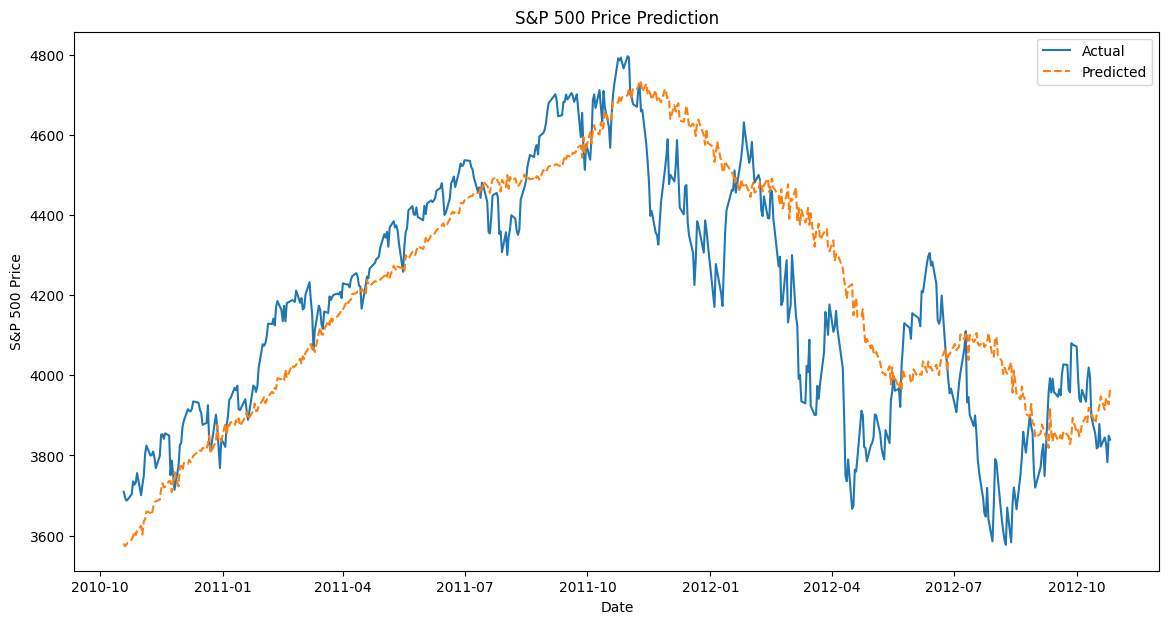

In [100]:
plt.figure(figsize=(14, 7))
plt.plot(data.index[1:len(actuals) + 1], actuals, label='Actual')
plt.plot(data.index[1:len(predictions) + 1], predictions, label='Predicted', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('S&P 500 Price')
plt.title('S&P 500 Price Prediction')
plt.legend()
plt.show()